# Imports

In [1]:
#!pip install plotly
#!pip install cufflinks

In [1]:
import pandas as pd
from sklearn import cluster as c
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing as pp

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px

from sklearn import metrics as m
import umap.umap_ as umap 


from IPython.core.display import HTML
from IPython.display import Image

# Funções Auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    sns.set(font_scale=1.6)
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# Data Load

In [12]:
data_raw = pd.read_csv('../Data/Ecommerce.csv')
data_raw = data_raw.drop(['Unnamed: 8'], axis=1)
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 - Descrição dos Dados

In [80]:
df1 = data_raw.copy()

## 1.1 - Rename Columns

In [81]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date' ,'unit_price', 'customer_id', 'country']

df1.columns = new_cols

## 1.2 - Dimensão dos Dados

In [82]:
print( 'Numero de Linhas: {}'.format(df1.shape[0]) )
print( 'Numero de Colunas: {}'.format(df1.shape[1]) )

Numero de Linhas: 541909
Numero de Colunas: 8


## 1.3 - Tipo dos Dados

In [83]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 - Check NA

In [84]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - Preencher NA

###  - Nesse ciclo vamos tentar achar alguma estratégia para não perder esses 25% da nossa base de dados

#### 1º Estratégia: Separar os dados em Missing e Not Missing. Desse modo, podemos tentar achar um invoice_no que existe em Missin e Not Missing ao mesmo tempo e assim recuperar o customer_id em Not Missing

In [85]:
# Para esse primeiro ciclo.. preferi dropar os dados NA
#df1 = df1.dropna(subset=['description', 'customer_id'])
#print('Percentual dropado: {:.2f}%'. format( 1- (df1.shape[0] / data_raw.shape[0]) ) )

df_missing = df1.loc[ df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), : ]


In [86]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
#missing_invoice[0:10]

In [87]:
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


#### Resultado: Podemos perceber que não existe nenhuma ocorrência que atenda a essas condições

#### 2º Estratégia: Criar um identificador único de cliente para as compras sem customer_id

In [88]:
#create reference

df_buckup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_buckup['customer_id'] = np.arange( 19000, 19000+ len(df_buckup), 1 )

#merge
df1 = pd.merge(df1, df_buckup, on = 'invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra coluns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis = 1)

df1.isna().sum()


invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [89]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 1.6 Alterar Tipo dos Dados

In [90]:
df1['customer_id'] = df1['customer_id'].astype( int )

df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

In [91]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


## 1.7 Estatística Descritiva

### 1.7.1 Numerical Attributes

In [92]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [93]:
# Medidas de Tendência Central (média, mediana)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Métricas de Dispersão (erro padrão, desvio Padrão, min, max, range, skew e kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

#Concatenando
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['Atributtes','min','max','range','media','mediana','desvio_padrao','skew','kurtosis']

metrics

,Atributtes,min,max,range,media,mediana,desvio_padrao,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097


### <font color='red'> 1.7.1.1 Numerical Attributs - Investigating

1. 'Quantity' negativa ( Pode ser devolução )

2. 'unit_price' igual a zero ( pode ser promoção? )

### 1.7.2 Categorical Attributes

In [94]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [95]:
cat_attributes.head()

,invoice_no,stock_code,description,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,17850


### Invoice Number

In [96]:
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply(lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates() )
#cat_attributes.loc[index, 'invoice_no'].head()

3839

### Stock Code

In [97]:
#len( cat_attributes.loc[ cat_attributes['stock_code'].apply(lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'stock_code'].drop_duplicates() )
cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Country

In [98]:
len( df1['country'].unique() )

38

In [99]:
df1['country'].value_counts(normalize= True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [105]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().head()

,country,customer_id
0,Australia,9
1,Austria,11
2,Bahrain,4
3,Belgium,25
4,Brazil,1


# 2.0 Filtragem de Variáveis

In [101]:
df2 = df1.copy()

In [102]:
# === Numerical Attributes ====

#unit price
df2 = df2.loc[df2['unit_price'] >= 0.040, : ]

# stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#description
df2 = df2.drop(columns= 'description')

#map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ] 


# quantity - Números Negativos
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

In [103]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


# 3.0 Feature Engineering

In [106]:
df3 = df2.copy()

## 3.1 Feature Creation

In [108]:
#data reference
df_ref = df3.drop( ['invoice_no','stock_code', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates(ignore_index=True)

# Gross Revenue ( Faturamento ) = quantity * price

df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

#Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')



# Recency - Last Day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
#df_ref.head()

# Number of returns

#df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'returns'})
#df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
#df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0


#df_ref.head()
#df_ref.isna().sum()





D:\programas\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# 4.0 Exploratory Data Analysis

In [353]:
df4 = df_ref.dropna().copy()

# 5.0 Data Preparation

In [385]:
df5 = df4.copy()

In [386]:
#df5.head()

In [405]:
ss = pp.StandardScaler()

#ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
#df5['returns'] = ss.fit_transform( df5[['returns']] )


In [406]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378060,2.791504,3.893137,-0.033930
1,13047,0.135805,-0.360996,0.621606,-0.033418
2,12583,0.525545,-0.899714,1.406774,-0.026613
3,13748,-0.120559,0.028079,0.098161,-0.023235
4,15100,-0.128667,2.402430,-0.163561,0.152452


# 6.0 Feature Selection

In [407]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [408]:
X = df6.drop( columns=['customer_id'] )

In [409]:
clusters = [2,3,4,5,6,7]

## 7.1 Within Cluster Sum of Square (WSS)

[]

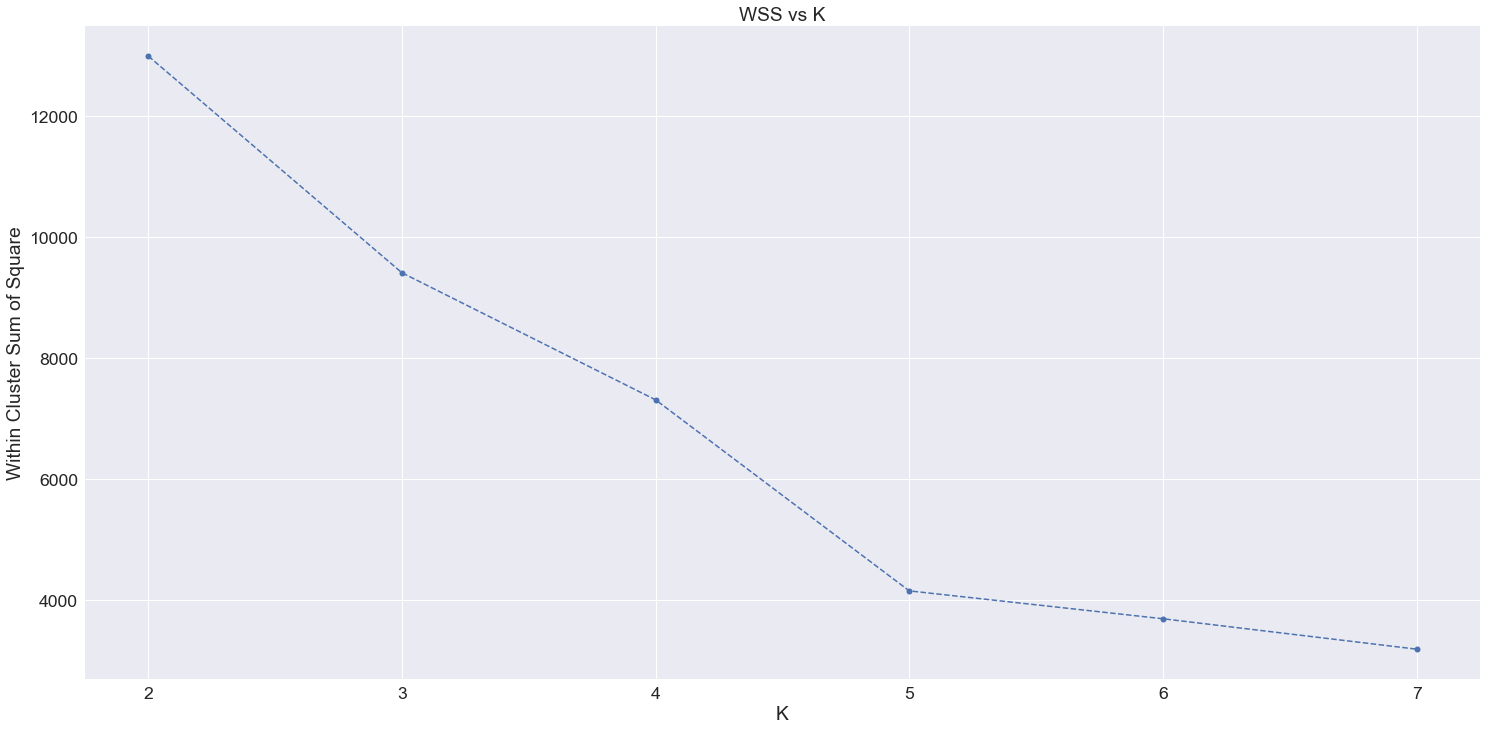

In [410]:
wss = []

for k in clusters:
    
    #model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model trainning
    kmeans.fit( X ) 
    
    #model validation
    wss.append(kmeans.inertia_)

    
#plot wss - Elbow Method
    
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Within Cluster Sum of Square');
plt.title('WSS vs K');
    
plt.plot()

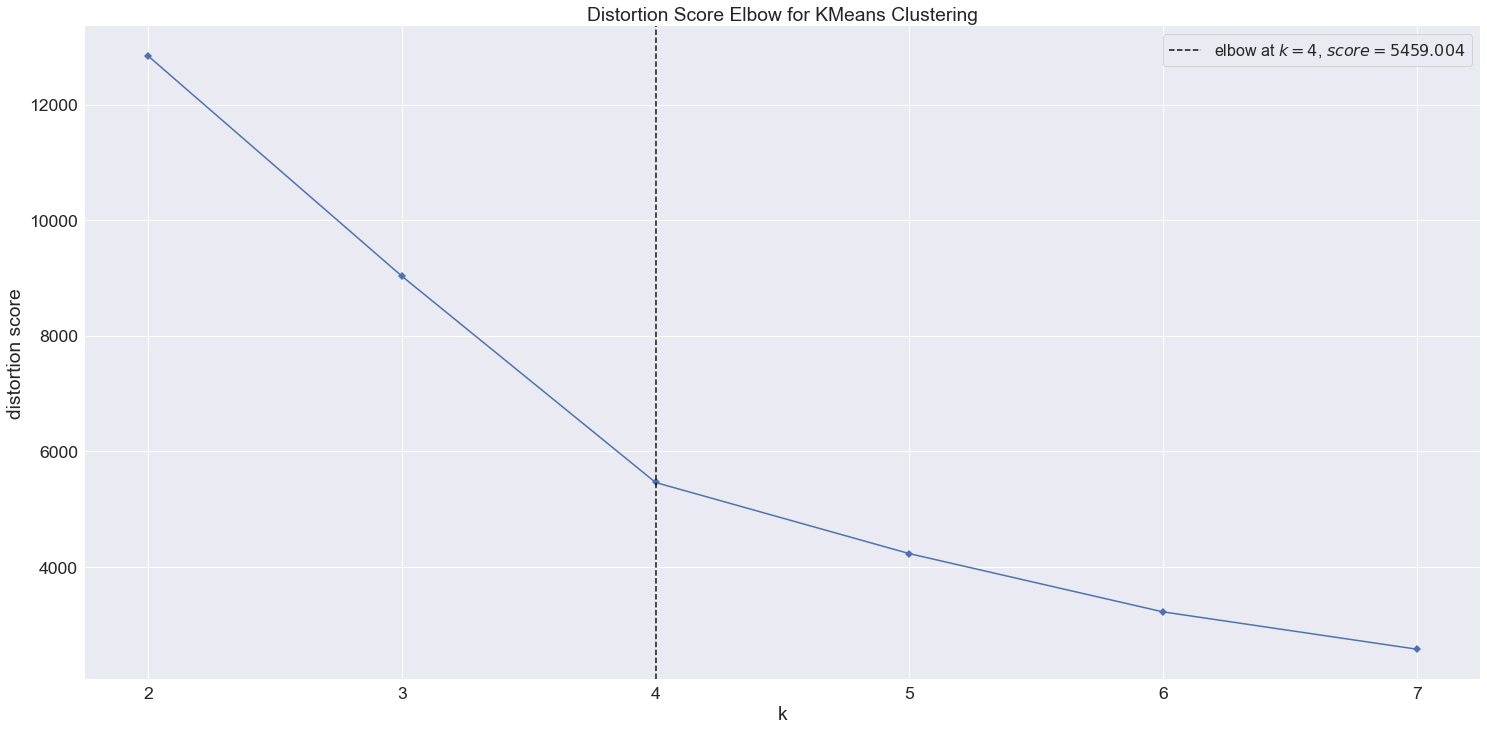

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [411]:


kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit(X)
kmeans.show()

## 7.1 Sillhouette Score

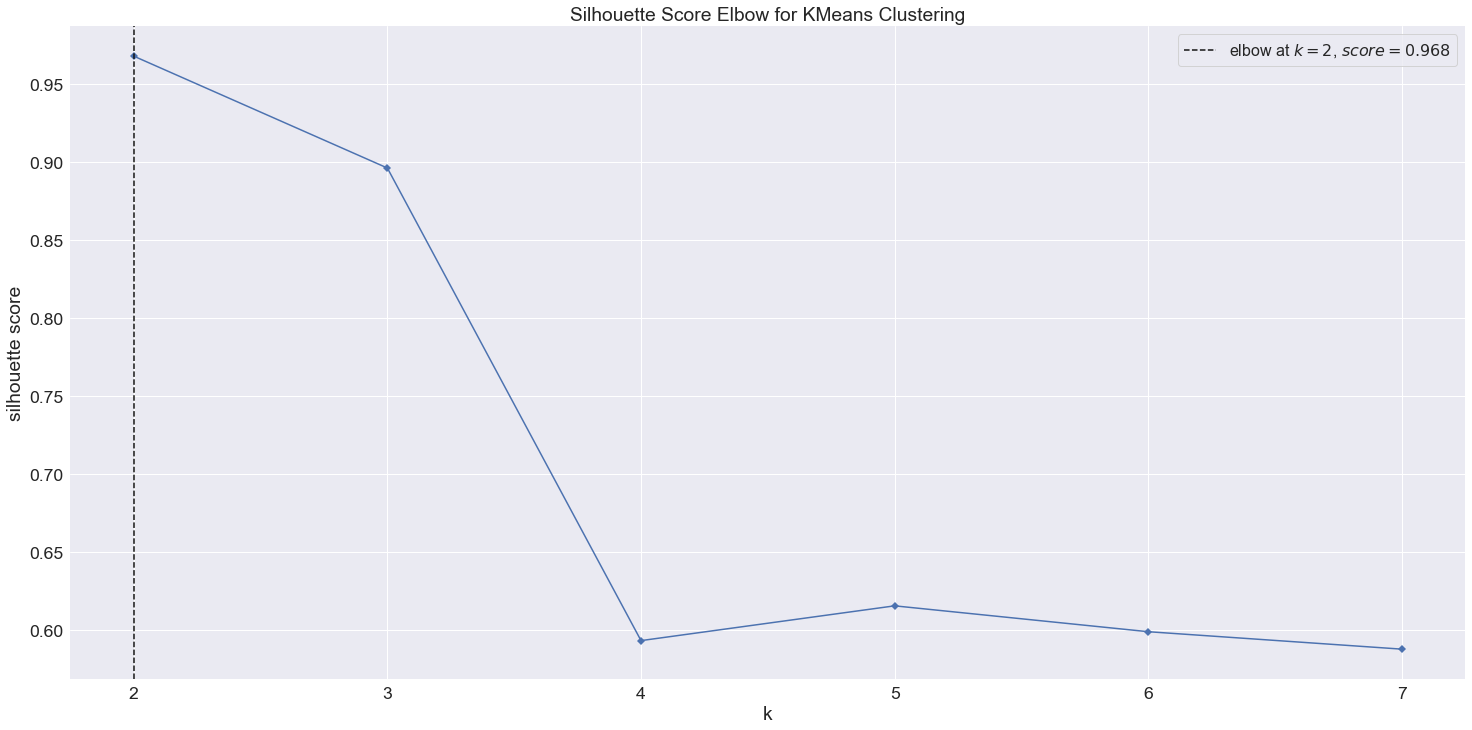

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [412]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Analysis 

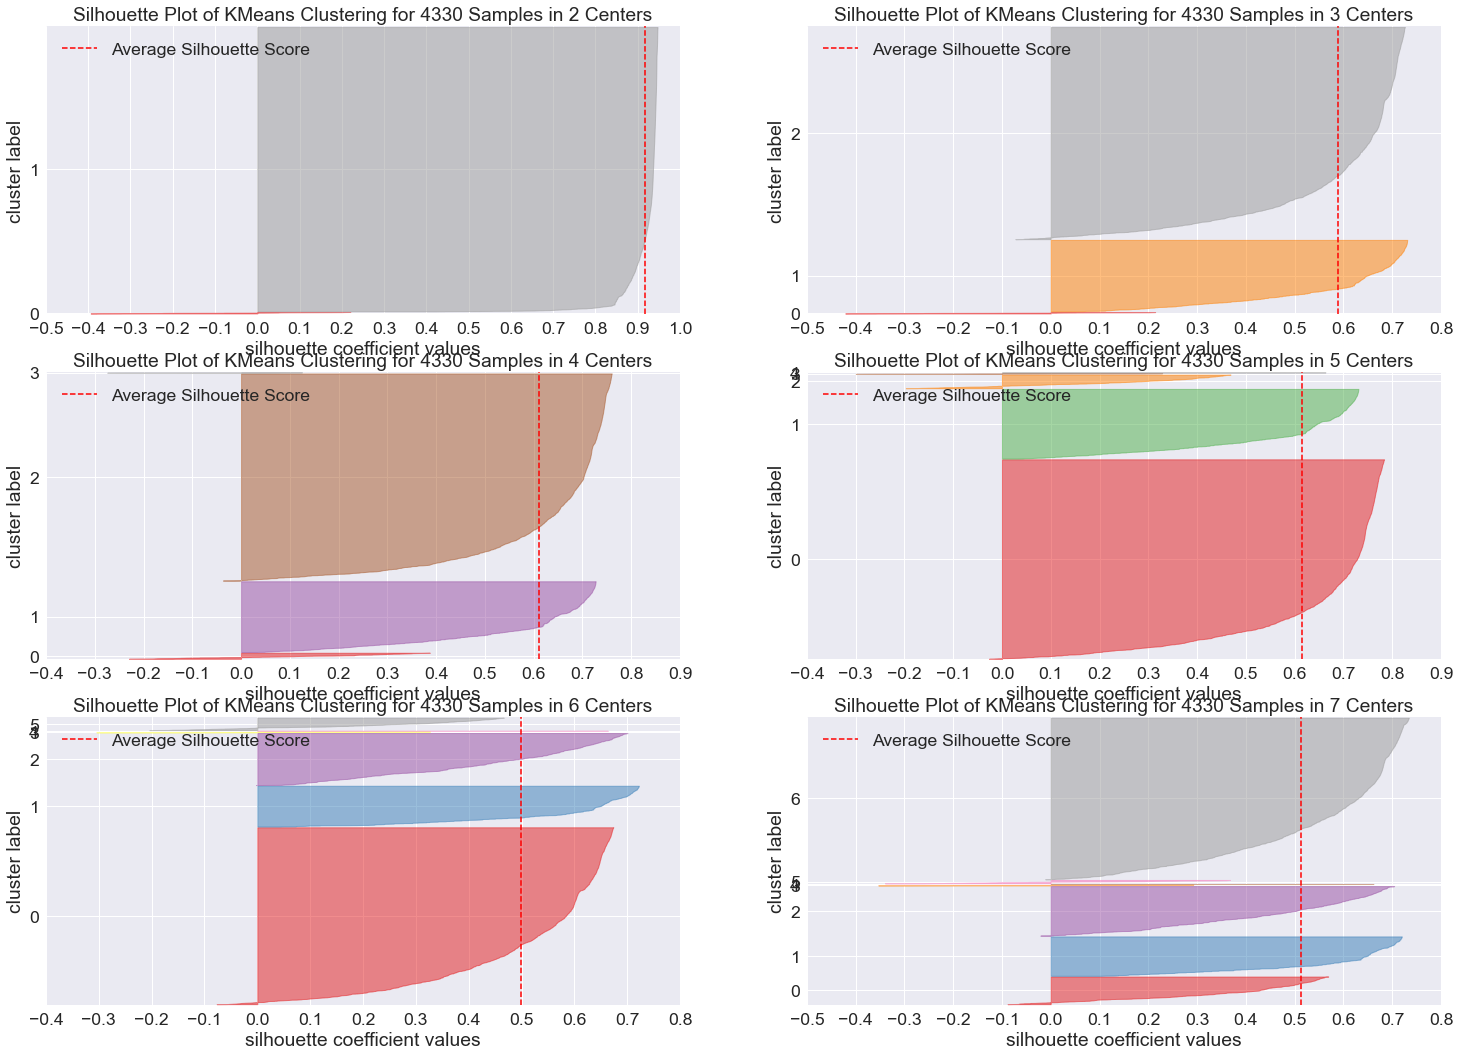

In [413]:
fig, ax = plt.subplots( 3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer( km, color = 'yellowbrick', ax= ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [427]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300)

# model trainning
kmeans.fit( X ) 

# clustering
#labels = kmeans.predict( X )
labels = kmeans.labels_


## 8.2 Cluster Validation

In [428]:
## WSS
print('WSS values: {}'.format(kmeans.inertia_) )



## SS
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )



WSS values: 9408.14108031406
SS value: 0.5893664818504057


# 9.0 Cluster Analysis

In [429]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspection

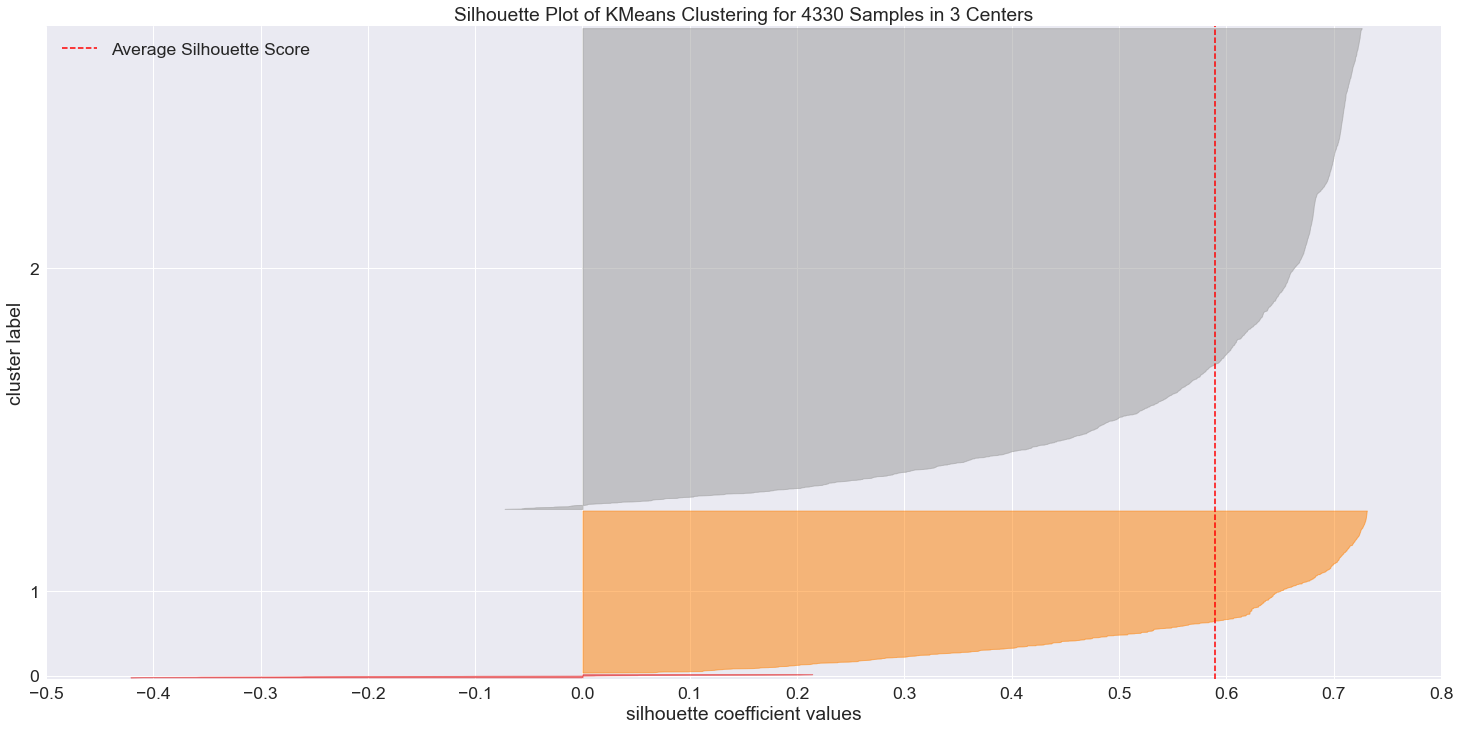

In [430]:
visualizer = SilhouetteVisualizer( kmeans, color = 'yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 9.2 2d plot

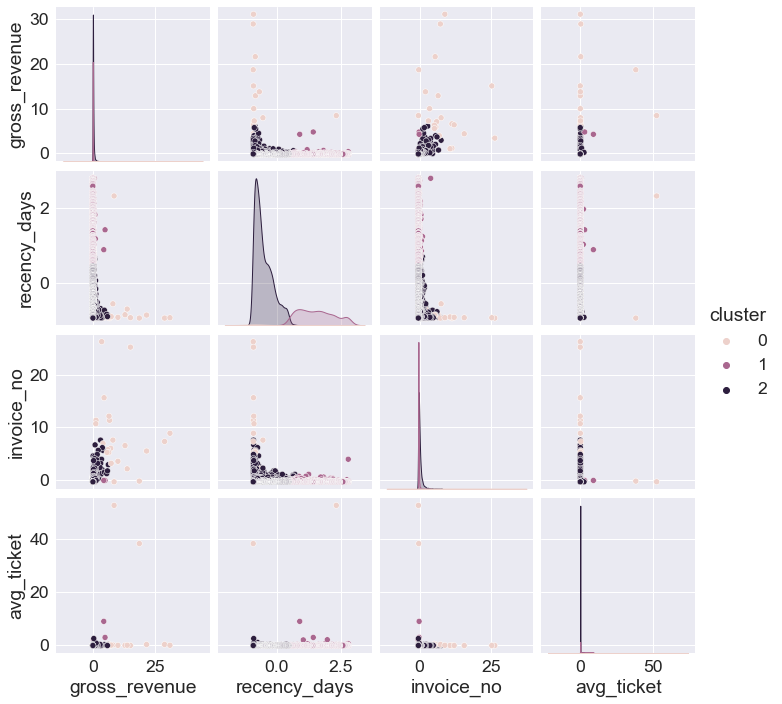

In [420]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [431]:
df_viz.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,cluster,embedding_x,embedding_y
0,0.378060,2.791504,3.893137,-0.033930,1,4.508737,-7.898502
1,0.135805,-0.360996,0.621606,-0.033418,2,0.246256,-4.096799
2,0.525545,-0.899714,1.406774,-0.026613,2,2.772799,-7.696093
3,-0.120559,0.028079,0.098161,-0.023235,2,0.281460,-1.459694
4,-0.128667,2.402430,-0.163561,0.152452,1,15.101659,1.498828


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

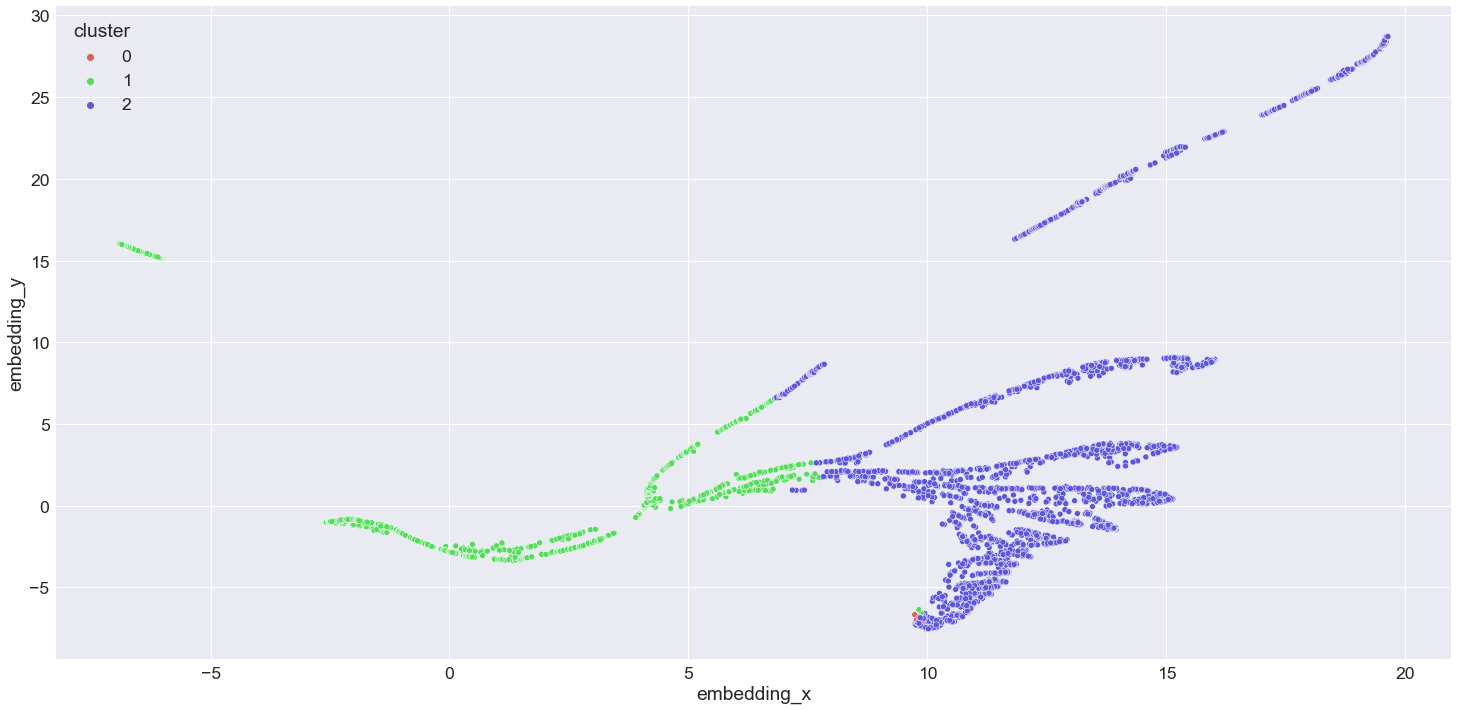

In [436]:
reducer = umap.UMAP(n_neighbors=90, random_state = 42 )
embedding = reducer.fit_transform( X )

#embedding

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors= len( df_viz['cluster'].unique() ) ),
                    data = df_viz
                )

In [433]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

## 9.2 Cluster Profile

In [434]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['percentual'] = df_cluster['customer_id'] / df_cluster['customer_id'].sum() * 100
#df_cluster

# Avg gross revenue
df_gross_revenue_cluster = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_gross_revenue_cluster, on='cluster', how='left' )
df_cluster


# Avg RECENCY
df_recency = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_recency, on='cluster', how='left' )
df_cluster


#Avg invoice
df_invoice = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
#df_gross_revenue_cluster['percentual'] = df_gross_revenue_cluster['gross_revenue'] / df_cluster['gross_revenue'].sum() * 100
df_cluster = pd.merge( df_cluster, df_invoice, on='cluster', how='left' )

#avg_ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_ticket, on='cluster', how='left' )

df_cluster 

,cluster,customer_id,percentual,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,22,0.508083,10.330215,-0.722409,8.437592,4.189466
1,1,1086,25.080831,-0.164755,1.538959,-0.350575,-0.008679
2,2,3222,74.411085,-0.015003,-0.513785,0.060552,-0.025680


## Cluster 01 (Candidato à Insider)

    - Número de Customers: 6 (0.13% dos clientes)

    - Recência em Média: 7 dias
    
    - Compras em Média: 89 compras
    
    - Receita em Média: 182.181,00 dolares
    
    - Ticket Médio: 253 dolares


## Cluster 02

     - Número de Customers: 28 (0.6% dos clientes)

     - Recência em Média: 6 dias
     
     - Compras em Média: 57 compras

     - Receita em Média: 42614 dolares
     
     - Ticket Médio: 162 dolares
     
     
## Cluster 03
    
    - Número de Customers: 267 (6% dos clientes)
    
    - Recência em Média: 20 dias
    
    - Compras em Média: 19 compras
    
    - Receita em Média: 8089 dolares
    
    - Ticket Médio: 62 dolares


## Cluster 04

     - Número de Customers: 4071 (93% dos clientes)

     - Recência em Média: 96 dias
     
     - Compras em Média: 3 compras
     
     - Receita em Média: 946 dolares


# 9.0 Deploy to Production